In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/home/jvcl/Downloads/archive/CostumerSegmentation/Data/marketing_campaign.csv', sep=';')

# Visualização inicial
print("Dimensões do dataset:", df.shape)
display(df.head())

Dimensões do dataset: (2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [6]:
print(df.dtypes)

# Exemplo: Converter colunas de datas (Dt_Customer) para datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d', errors='coerce')

# Verificar valores ausentes
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

# Exemplo: remover linhas com Income nulo (caso existam)
df = df.dropna(subset=['Income'])

# Excluir outliers em Year_Birth (ex.: pessoas com mais de 100 anos ou menos de 18, se fizer sentido)
# Aqui, como exemplo, vamos manter apenas clientes nascidos entre 1920 e 2003
df = df[(df['Year_Birth'] >= 1920) & (df['Year_Birth'] <= 2003)]

# Resetar index após remoções
df.reset_index(drop=True, inplace=True)

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

Valores ausentes por coluna:
ID                      0
Year_Birth              0
Educa

In [7]:
# ===============================
# 4) Feature Engineering
# ===============================
# 4.1) Criando colunas derivadas

# Idade (aproximada)
current_year = 2025  # Ajuste conforme o ano de análise
df['Age'] = current_year - df['Year_Birth']

# Tempo como cliente (em dias, meses ou anos) - Exemplo em dias
df['Customer_For_Days'] = (pd.to_datetime('2025-01-01') - df['Dt_Customer']).dt.days

# Soma total de gastos (em todas as categorias de produto)
df['TotalMnt'] = (df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] +
                  df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds'])

# Soma total de compras (número de compras em todos os canais)
df['TotalPurchases'] = (df['NumDealsPurchases'] + df['NumWebPurchases'] +
                        df['NumCatalogPurchases'] + df['NumStorePurchases'])

In [8]:
# 4.2) Selecionando variáveis relevantes para o clustering
# Você pode incluir/excluir colunas conforme seu objetivo.
features = [
    'Age',
    'Income',
    'Recency',
    'TotalMnt',
    'TotalPurchases',
    'Kidhome',
    'Teenhome',
    # Exemplo: se quiser analisar também o "AcceptedCmpX", inclua aqui
]

df_cluster = df[features].copy()

In [9]:
# ===============================
# 5) Escalonamento (Scaling)
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [10]:
# ===============================
# 6) Definindo o número de Clusters
# ===============================
wcss = []  # Within-Cluster Sum of Squares
silhouette_scores = []

K_MAX = 10  # Você pode ajustar esse valor
for k in range(2, K_MAX+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    wcss.append(kmeans.inertia_)
    
    # Cálculo do silhouette
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)


Text(0, 0.5, 'WCSS')

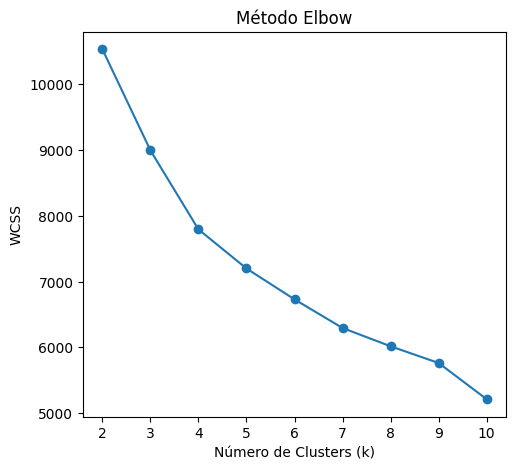

In [11]:
# Plot do método Elbow
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, K_MAX+1), wcss, marker='o')
plt.title('Método Elbow')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')

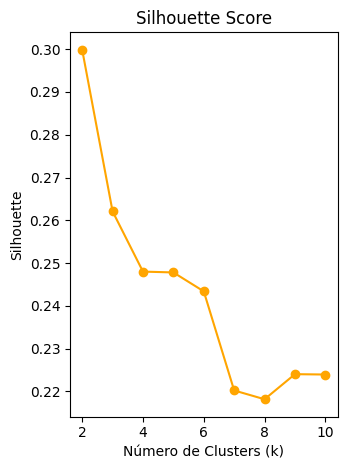

In [12]:
# Plot do silhouette score
plt.subplot(1, 2, 2)
plt.plot(range(2, K_MAX+1), silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette')

plt.tight_layout()
plt.show()

In [13]:
k_final = 4

In [14]:
# ===============================
# 7) Modelagem K-Means Final
# ===============================
kmeans = KMeans(n_clusters=k_final, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Adicionando rótulos de cluster ao dataframe original
df['Cluster'] = cluster_labels

In [15]:
# ===============================
# 8) Análise dos Clusters
# ===============================
# Estatísticas descritivas por cluster
cluster_summary = df.groupby('Cluster')[features + ['TotalMnt', 'TotalPurchases']].mean()
display(cluster_summary)

,Age,Income,Recency,TotalMnt,TotalPurchases,Kidhome,Teenhome,TotalMnt,TotalPurchases
Cluster,,,,,,,,,
0,56.318436,76670.633147,49.130354,1350.379888,20.355680,0.068901,0.005587,1350.379888,20.355680
1,46.844444,30166.000000,48.962393,117.476923,8.235897,0.842735,0.000000,117.476923,8.235897
2,60.748276,61398.996552,48.291379,840.600000,21.663793,0.106897,1.051724,840.600000,21.663793
3,61.115460,41426.412916,49.743640,121.160470,9.074364,0.755382,0.990215,121.160470,9.074364


In [16]:
# Podemos também ver quantos clientes há em cada cluster
cluster_counts = df['Cluster'].value_counts().sort_index()
print("Contagem de clientes por cluster:")
print(cluster_counts)

Contagem de clientes por cluster:
0    537
1    585
2    580
3    511
Name: Cluster, dtype: int64


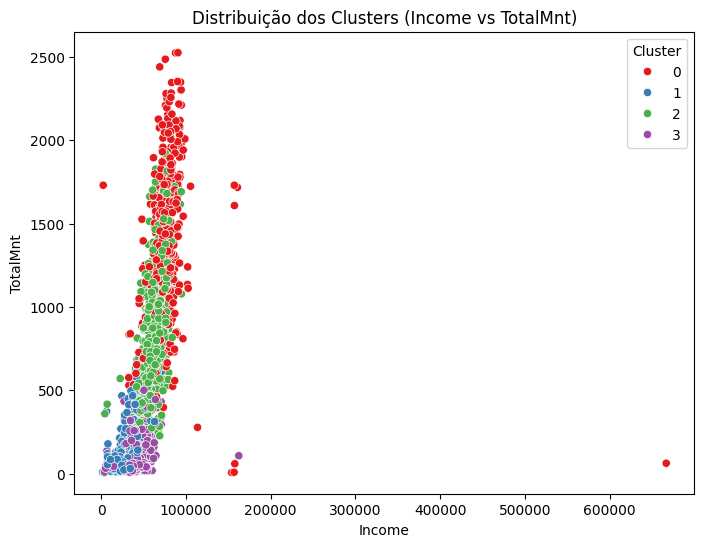

In [17]:
# Visualização simples (usando duas variáveis, via PCA ou manualmente)
# Exemplo rápido (2D) com duas features apenas, sem PCA (apenas para ilustração)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df['Income'], 
    y=df['TotalMnt'], 
    hue=df['Cluster'], 
    palette='Set1'
)
plt.title('Distribuição dos Clusters (Income vs TotalMnt)')
plt.show()

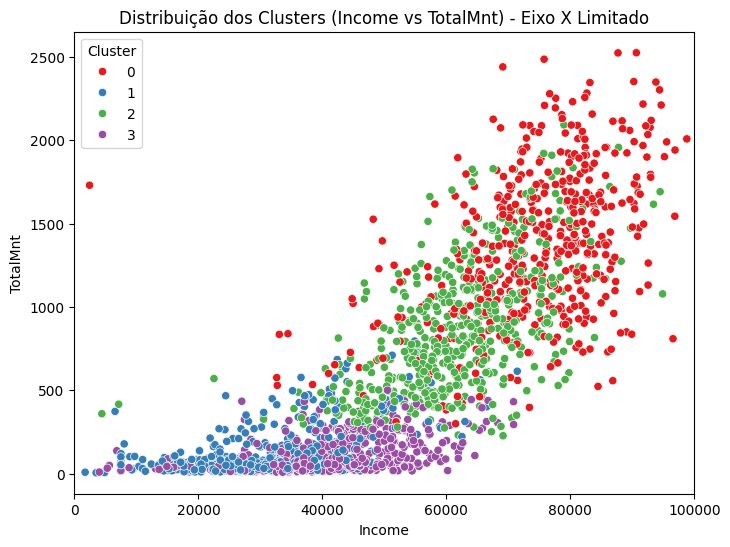

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Income'], y=df['TotalMnt'], hue=df['Cluster'], palette='Set1')
plt.title('Distribuição dos Clusters (Income vs TotalMnt) - Eixo X Limitado')

# Limita o eixo X para visualizar melhor a maioria dos dados
plt.xlim(0, 100000)

plt.show()

### Exemplo de Descrição de Clusters

---

**Cluster 0 (vermelho) – “High Spenders”**

- Gasto total alto (ex.: média de 1500).  
- Renda variada (alguns podem estar se endividando ou priorizando certos produtos).  
- Provavelmente aceitam bem campanhas de produtos premium.  

**Estratégia de Marketing**: Focar em ofertas de alto valor agregado, programas de fidelidade e experiências exclusivas.

---

**Cluster 1 (verde) – “Mid-Level Spenders”**

- Gasto total médio (ex.: média de 600-800).  
- Renda geralmente média, possivelmente com hábitos de compra mais equilibrados.  
- Bom público para campanhas de upsell ou cross-sell, pois têm potencial para aumentar gasto.  

**Estratégia de Marketing**: Destacar produtos que ofereçam bom custo-benefício, além de incentivar a experimentação de novas categorias.

---

**Cluster 2 (azul) – “Lower Spend, Medium Income”**

- Gasto total abaixo do verde, mas ainda não o menor de todos.  
- Podem ser clientes “indiferentes” a promoções ou focados em poucas categorias específicas.  
- Estratégia: campanhas que estimulem maior frequência ou maior ticket médio.  

**Estratégia de Marketing**: Criar ofertas direcionadas que estimulem compras recorrentes e aumentem a percepção de valor em categorias ainda não exploradas.

---

**Cluster 3 (roxo) – “Low Spenders / Baixo Engajamento”**

- Baixo gasto total, mesmo com renda que às vezes não é tão baixa.  
- Podem estar pouco fidelizados ou só compram em ocasiões pontuais.  
- Poderiam ser alvo de campanhas de reativação ou ofertas de menor risco (descontos iniciais).  

**Estratégia de Marketing**: Focar em reativação, com cupons de desconto e promoções que reduzam a barreira de entrada para compras mais frequentes.


In [19]:
def label_cluster(row):
    if row['Cluster'] == 0:
        return "Cluster 0: (perfil X)"
    elif row['Cluster'] == 1:
        return "Cluster 1: (perfil Y)"
    elif row['Cluster'] == 2:
        return "Cluster 2: (perfil Z)"
    else:
        return "Cluster 3: (perfil W)"

df['Cluster_Label'] = df.apply(label_cluster, axis=1)